In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.spatial import distance_matrix
import opt_einsum

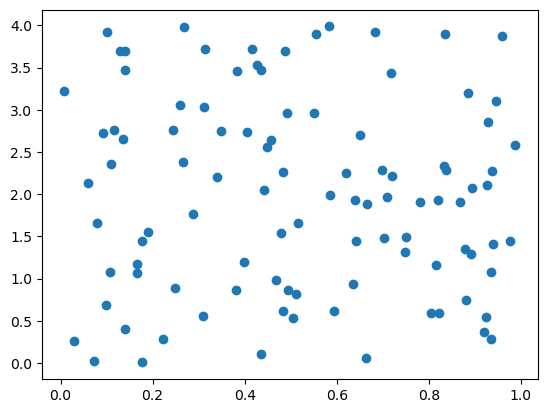

In [4]:
mus = np.random.uniform([0,0],[1,4],size=(100,2))
plt.scatter(mus[:,0],mus[:,1])

In [19]:
class GRF:
    def __init__(self, N_samples, l, device):
        super().__init__()
        self.device = device
        self.N_samples = N_samples #Number of GRF samples
        self.l = torch.tensor(l, device=self.device) #Length scale of GRF
        self.d = len(l) #Dimensionality of GRF
        self.n_mus = int(max(10,1/torch.prod(self.l))) #Number of GRF sample locations per volume element 1/l^d
        self.mus = self.compute_mus()
        self.f_hat = self.compute_RBFintcoeffs()
        self.mus = torch.tensor(self.mus, device=self.device)

    #Sample n_samples_per_l/l^d random points on the unit square
    def compute_mus(self):
        mus = np.random.uniform(0,1,size=(self.n_mus,self.d))
        return mus

    #Compute Gaussian covariance matrix cov between points
    def compute_cov(self):
        # cov = np.ones((self.n_mus,self.n_mus))
        # for i in range(self.d):
        #     cov *= np.exp(-distance_matrix(self.mus[:,i], self.mus[:,i], p=2)**2/(2*self.l[i]**2))
        l = self.l.detach().cpu().numpy()
        cov = np.exp(-1/2*distance_matrix(self.mus/l[None,:], self.mus/l[None,:], p=2)**2)
        return cov
    
    #Sample from a multivariate Gaussian with covariance cov
    def compute_GRFpoints(self, cov):
        f = np.random.multivariate_normal(np.zeros(self.n_mus), cov=cov, size=self.N_samples)
        return f
    
    #Interpolate the GRF with Gaussian RBFs
    def compute_RBFintcoeffs(self):
        cov = self.compute_cov()
        f = self.compute_GRFpoints(cov)
        cov = torch.tensor(cov, device=self.device)
        cov_inv = torch.linalg.inv(cov)
        f = torch.tensor(f, device=self.device)
        f_hat = opt_einsum.contract('ij,nj->ni', cov_inv, f)
        return f_hat
    
    def phi_n(self, x):
        output = self.f_hat[i,None,:]*torch.exp(-1/2*torch.sum(((x[:,None,:] - self.mus[None,:,:])/self.l[None,None,:])**2, dim=-1))
        return output
    
    #Forward evaluation of RBF interpolated GRF
    def forward(self, i):
        def function(x):
            phi_n = self.phi_n(x)
            return torch.sum(phi_n, dim=1)
        return function

    #Pointwise forward evaluation of RBF interpolated GRF (required for Nutils)
    def forward_nutils(self, i):
        def function(x):
            phi_n = self.f_hat[i]*np.exp(-np.sum((x - self.mus)**2, axis=-1)/(2*self.l**2))
            return np.sum(phi_n)
        return function
    
    #Gradient of RBF interpolated GRF
    def grad(self, i):
        def function(x):
            phi_n = self.phi_n(x)
            prefactor = -1/(self.l[None,None,:]**2)*(x[:,None,:] - self.mus[None,:,:])
            return torch.sum(prefactor*phi_n[:,:,None], dim=1)
        return function

    #Laplacian of RBF interpolated GRF
    def laplacian(self, i):
        def function(x):
            phi_n = self.phi_n(x)
            prefactor = torch.sum((x[:,None,:] - self.mus[None,:,:])**2/self.l[None,None,:]**4 - 1/self.l[None,None,:]**2, axis=-1)
            return torch.sum(prefactor*phi_n, dim=1)
        return function

In [36]:
l = [0.05,0.2,0.5]
grf = GRF(N_samples=100, l=l, device='cpu')

In [37]:
X, Y, Z = np.mgrid[0:1:int(1/l[0])*1j, 0:1:int(1/l[1])*1j, 0:1:int(1/l[2])*1j]
x_i = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T


In [39]:
x_i

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.25      , 0.        ],
       [0.        , 0.25      , 1.        ],
       [0.        , 0.5       , 0.        ],
       [0.        , 0.5       , 1.        ],
       [0.        , 0.75      , 0.        ],
       [0.        , 0.75      , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 1.        ],
       [0.05263158, 0.        , 0.        ],
       [0.05263158, 0.        , 1.        ],
       [0.05263158, 0.25      , 0.        ],
       [0.05263158, 0.25      , 1.        ],
       [0.05263158, 0.5       , 0.        ],
       [0.05263158, 0.5       , 1.        ],
       [0.05263158, 0.75      , 0.        ],
       [0.05263158, 0.75      , 1.        ],
       [0.05263158, 1.        , 0.        ],
       [0.05263158, 1.        , 1.        ],
       [0.10526316, 0.        , 0.        ],
       [0.10526316, 0.        , 1.        ],
       [0.

In [33]:
grf.forward(i=0)(torch.tensor(x_i))

tensor([ 0.2303,  0.0278,  1.4091,  1.0331,  0.9894,  1.0100, -1.0355, -0.5527,
        -1.2237, -0.4996,  0.1234, -0.3688,  0.6657, -0.3142,  0.7921, -0.8239,
         0.3384, -1.3848, -0.6051, -0.4191,  0.0833, -0.2805, -0.9325, -0.9544,
        -0.7394, -1.4750,  0.7563, -1.3911,  0.6765,  0.1919,  0.6433,  0.1555,
        -0.8615, -0.6778, -1.3510, -1.7482,  0.3978, -1.2210,  1.4339,  0.7748,
         0.7961, -0.3565, -0.7626, -0.8450, -0.3787, -0.8972,  0.7435,  0.5949,
         1.0875,  1.4332,  0.4138, -1.0198, -0.1157,  0.4099,  0.6380,  0.0654,
         0.5536,  1.7120,  0.0411,  1.6476, -0.1826, -1.3501,  0.5778,  1.7802,
         0.9020,  1.4044,  0.1815,  1.7634,  0.1919,  1.0553, -0.3722, -0.5569,
         0.5312,  0.8608,  0.5322,  0.4614,  0.3721,  0.8277,  0.6005,  0.9922,
        -0.4693,  0.4686,  1.4806,  0.9580,  0.7959, -0.2908,  0.5182,  0.0703,
         0.6934,  0.8932, -1.1451,  0.2003,  0.1177,  0.4267, -0.5161, -0.0654,
        -0.6890,  0.3961,  0.0774,  0.39

/tmp/ipykernel_443383/1553854103.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fig = ax.tripcolor(x_i[:,0], x_i[:,2], grf.forward(i=i)(torch.tensor(x_i))


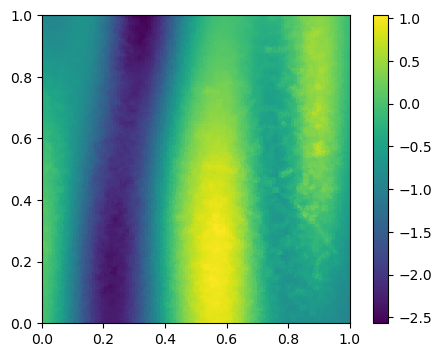

In [ ]:
i=0
X, Y, Z = np.mgrid[0:1:100*1j, 0:1:100*1j, 0:1:100*1j]
x_i = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
x_i = torch.tensor(x_i)

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.tripcolor(x_i[:,0], x_i[:,2], grf.forward(i=i)(torch.tensor(x_i))
)
# ax.set_title(r"$u(\mathbf{x})$", fontsize=size_title)
# ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
# ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
# ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)
# plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1)

plt.savefig("GRF.svg", bbox_inches='tight', transparent=True)

/tmp/ipykernel_4139393/1333558162.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fig = ax.tripcolor(x_i[:,0], x_i[:,1], torch.sum(grf.grad(i=i)(torch.tensor(x_i))**2, axis=-1))


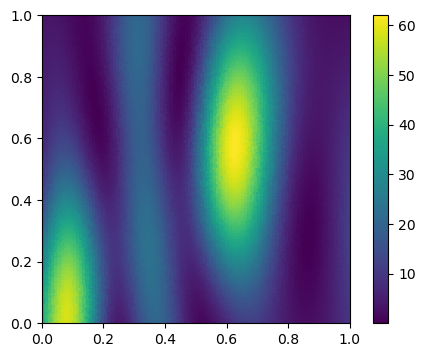

In [305]:
i=0
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.vstack([X.ravel(), Y.ravel()]).T
x_i = torch.tensor(x_i)
fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.tripcolor(x_i[:,0], x_i[:,1], torch.sum(grf.grad(i=i)(torch.tensor(x_i))**2, axis=-1))

# ax.set_title(r"$u(\mathbf{x})$", fontsize=size_title)
# ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
# ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
# ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)
# plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1)

plt.savefig("GRF.svg", bbox_inches='tight', transparent=True)

/tmp/ipykernel_4139393/1938790313.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fig = ax.tripcolor(x_i[:,0], x_i[:,1], grf.laplacian(i=i)(torch.tensor(x_i)))


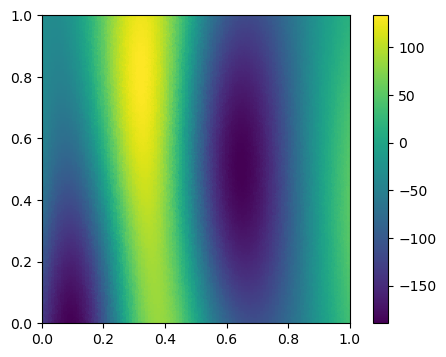

In [306]:
i=0
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.vstack([X.ravel(), Y.ravel()]).T
x_i = torch.tensor(x_i)
fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.tripcolor(x_i[:,0], x_i[:,1], grf.laplacian(i=i)(torch.tensor(x_i)))

# ax.set_title(r"$u(\mathbf{x})$", fontsize=size_title)
# ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
# ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
# ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)
# plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1)

plt.savefig("GRF.svg", bbox_inches='tight', transparent=True)